<a href="https://colab.research.google.com/github/jinhyung426/tensorflow/blob/main/tf_chap2_cnn_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Part 2. Convolutional Neural Networks in TensorFlow

## (1) Preventing Overfitting - Data Augmentation & Dropouts

In [1]:
import os
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model

import numpy as np
import random
from shutil import copyfile

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2021-01-30 12:46:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   104MB/s    in 1.4s    

2021-01-30 12:46:25 (104 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [3]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

In [4]:
print(len(os.listdir('/tmp/horse-or-human/horses')))
print(len(os.listdir('/tmp/horse-or-human/humans')))

500
527


# Splitting Data into Training and Testing Data

In [5]:
try:
  os.makedirs('/tmp/horse-or-human/training/horses')
  os.makedirs('/tmp/horse-or-human/training/humans')
  os.makedirs('/tmp/horse-or-human/testing/horses')
  os.makedirs('/tmp/horse-or-human/testing/humans')
except OSError:
  print('Making directories failed') # If the path already exists, then it will trigger error

# Splitting Data

1. from shutil import copyfile
2. os.path.getsize(filepath) 이용해서 size가 0인 file 제외
3. copyfile(filepath1, filepath2)에는 각각 path + name 형태로 적어주어야함
3. 각 path 앞뒤로 / 붙이기 잊지말기 (뒤에는 붙어도 상관없음)

In [6]:
def split_data(source, training_dest, testing_dest, split_ratio):
  total_files = os.listdir(source)
  num_files = len(total_files)
  num_train = int(num_files * split_ratio)
  
  total_files = random.sample(total_files, num_files)  # shuffle
  
  for i in range(num_train):
    if os.path.getsize(source + total_files[i]) != 0:
      copyfile(source + total_files[i], training_dest + total_files[i])

  for i in range(num_train, num_files):
    if os.path.getsize(source + total_files[i]) != 0:
      copyfile(source + total_files[i], testing_dest + total_files[i])


HORSE_SOURCE = '/tmp/horse-or-human/horses/'
HUMAN_SOURCE = '/tmp/horse-or-human/humans/'
HORSE_TRAINING_DEST = '/tmp/horse-or-human/training/horses/'
HUMAN_TRAINING_DEST = '/tmp/horse-or-human/training/humans/'
HORSE_TESTING_DEST = '/tmp/horse-or-human/testing/horses/'
HUMAN_TESTING_DEST = '/tmp/horse-or-human/testing/humans/'
SPLIT_RATIO = 0.9

split_data(HORSE_SOURCE, HORSE_TRAINING_DEST, HORSE_TESTING_DEST, SPLIT_RATIO)
split_data(HUMAN_SOURCE, HUMAN_TRAINING_DEST, HUMAN_TESTING_DEST, SPLIT_RATIO)

In [7]:
print(len(os.listdir('/tmp/horse-or-human/training/horses/')))
print(len(os.listdir('/tmp/horse-or-human/training/humans/')))
print(len(os.listdir('/tmp/horse-or-human/testing/horses/')))
print(len(os.listdir('/tmp/horse-or-human/testing/humans/')))

450
474
50
53


In [8]:
train_horse_names = os.listdir(HORSE_TRAINING_DEST)
print(train_horse_names[:10])

train_human_names = os.listdir(HUMAN_TRAINING_DEST)
print(train_human_names[:10])

validation_horse_hames = os.listdir(HORSE_TESTING_DEST)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(HUMAN_TESTING_DEST)
print(validation_human_names[:10])

['horse33-8.png', 'horse35-3.png', 'horse30-3.png', 'horse39-0.png', 'horse34-0.png', 'horse31-5.png', 'horse25-0.png', 'horse21-1.png', 'horse22-6.png', 'horse05-8.png']
['human01-16.png', 'human06-05.png', 'human13-03.png', 'human14-10.png', 'human05-15.png', 'human11-21.png', 'human01-09.png', 'human12-30.png', 'human01-15.png', 'human17-04.png']
['horse17-1.png', 'horse18-1.png', 'horse32-9.png', 'horse12-4.png', 'horse16-3.png', 'horse39-9.png', 'horse47-2.png', 'horse12-0.png', 'horse25-2.png', 'horse36-5.png']
['human17-22.png', 'human14-27.png', 'human10-13.png', 'human10-15.png', 'human12-18.png', 'human05-05.png', 'human15-13.png', 'human03-26.png', 'human17-16.png', 'human13-02.png']


In [9]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

In [10]:
next_horse_pix = [os.path.join(HORSE_TRAINING_DEST, fname) for fname in train_horse_names[:8]]
next_human_pix = [os.path.join(HUMAN_TRAINING_DEST, fname) for fname in train_human_names[:8]]

# Subplots

-  subplot = plt.subplot(num_rows, num_columns, i)  --> i starts with 1
-  image = mpimg.imread(img_path)  
-  plt.imshow(image)

- 다 한 후에, plt.show()

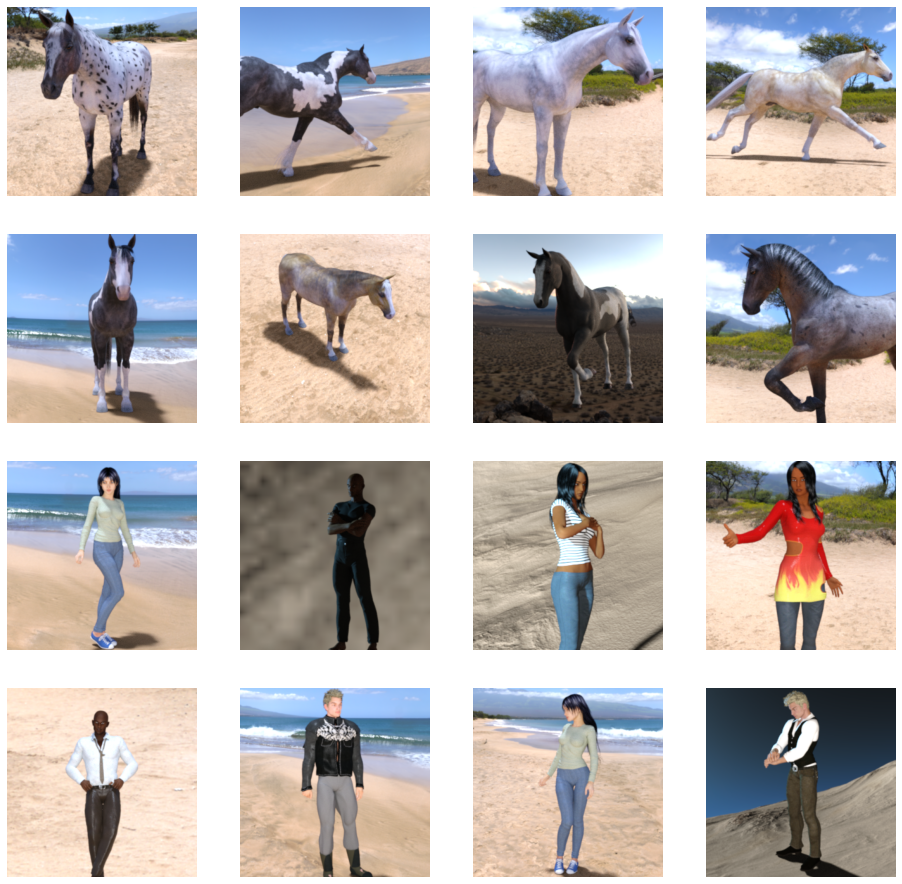

In [11]:
# Get current figure. If no current figure exists, a new one is created using figure().
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(next_horse_pix + next_human_pix):
  # Set up subplots - subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Dropout

1. Regularization technique that **spread out the weights** by eliminating random neurons to prevent overfitting and over-specialization (similar to L2 regularization)

2. **Add dropout** in the **layer with many neurons**
   * Since neighbor neurons may have similar weights and affect each other, it may skew the final training which leads to overfitting
  * For layers with few neurons, don't use high dropout
  * For input layer, it is typical to keep the keep_prob to be 1.0
  * keep_prob = 1 - dropout

3. Downside

   1) Cost function is not well defined since it is hard to calculate

   2) Cost function may not be a monotonic decreasing function

   -  Therefore, we first experiment with keep_prob = 1 and check if the cost function is monotonically decreasing, then use Dropout


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')  # 0 for horses, 1 for humans or vice versa

])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

# Image Augmentation / Data Augmentation
  - ImageDataGenerator를 통해 구현
  - Original image는 보존하고, changes the images on the fly (in-memory) but takes more processing time
  - Validation Data도 train data처럼 random해야 val loss가 fluctuate하지 않음


# ImageDataGenerator
1. from tensorflow.keras.preprocessing.image import ImageDataGenerator

2. 객체 생성시
  - rescale
  - zoom_range
  - width_shift_range
  - height_shift_range
  - shear_range
  - rotation_range
  - horizontal_flip
  - fill_mode

3. flow_from_directory
  - path : 해당 path 안에 subdirectories (human/horse)가 존재해야함
  - target_size : channel 개수 빼고 적을 것
  - class_mode : binary / categorical




In [17]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/training/',
    target_size=(300, 300),
    batch_size=20,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/tmp/horse-or-human/testing/',
    target_size=(300, 300),
    batch_size=20,
    class_mode = 'binary'
)


Found 924 images belonging to 2 classes.
Found 103 images belonging to 2 classes.


In [18]:
history = model.fit(
    train_generator,
    # steps_per_epoch
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
    # validation_step
)

Epoch 1/15
47/47 [==============================] - 29s 452ms/step - loss: 0.8717 - accuracy: 0.5184 - val_loss: 0.5882 - val_accuracy: 0.7864
Epoch 2/15
47/47 [==============================] - 21s 446ms/step - loss: 0.6249 - accuracy: 0.6863 - val_loss: 0.4183 - val_accuracy: 0.7476
Epoch 3/15
47/47 [==============================] - 21s 446ms/step - loss: 0.4875 - accuracy: 0.7834 - val_loss: 0.3271 - val_accuracy: 0.8544
Epoch 4/15
47/47 [==============================] - 21s 446ms/step - loss: 0.4148 - accuracy: 0.8223 - val_loss: 0.2355 - val_accuracy: 0.9417
Epoch 5/15
47/47 [==============================] - 21s 446ms/step - loss: 0.3443 - accuracy: 0.8454 - val_loss: 0.2305 - val_accuracy: 0.8835
Epoch 6/15
47/47 [==============================] - 21s 446ms/step - loss: 0.3090 - accuracy: 0.8747 - val_loss: 0.8602 - val_accuracy: 0.8641
Epoch 7/15
47/47 [==============================] - 21s 449ms/step - loss: 0.3743 - accuracy: 0.8795 - val_loss: 0.0984 - val_accuracy: 0.9903

# Walking Through Convolutions

1. layer_outputs = [layer.output for layer in model.layers[1:]]
2. layer_names = [layer.name for layer in model.layers[1:]]
3. activation_model = Model(inputs=model.input, outputs=layer_outputs)
4. Predict후 결과값안에서 layer_output별로 iterate하기

In [19]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_names = [layer.name for layer in model.layers[1:]]

visualization_model = Model(inputs=model.input, outputs=layer_outputs)

In [29]:
horse_img_files = [os.path.join(HORSE_TRAINING_DEST, f) for f in train_horse_names]
human_img_files = [os.path.join(HUMAN_TRAINING_DEST, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path)   # This is a PIL image
x = img_to_array(img)      # converts to numpy array

In [30]:
x = np.expand_dims(x, axis=0)
x = x / 255
x.shape

(1, 300, 300, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


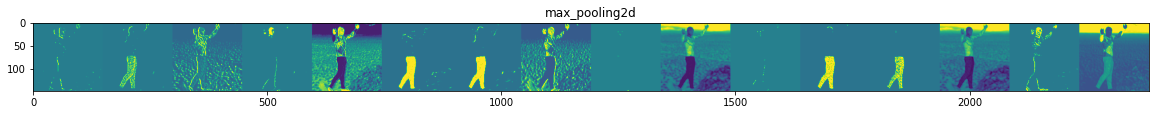

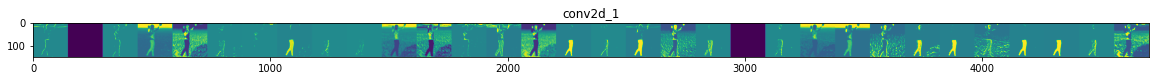

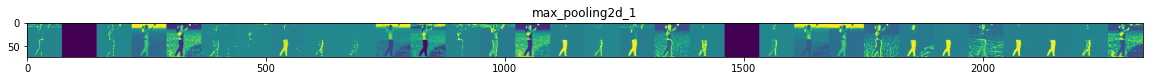

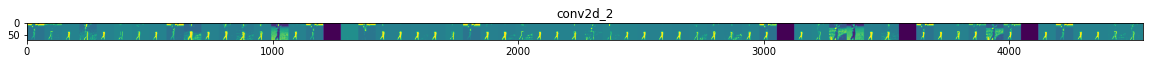

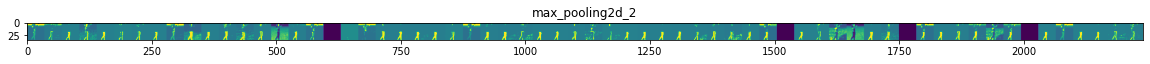

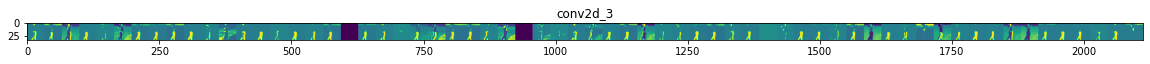

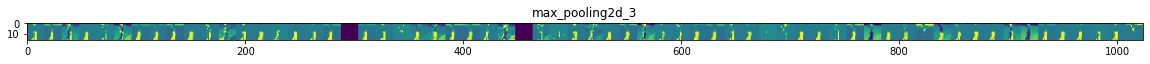

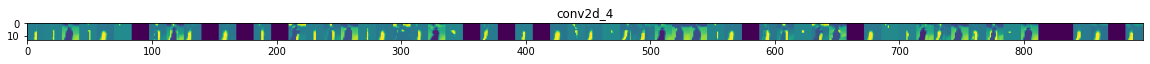

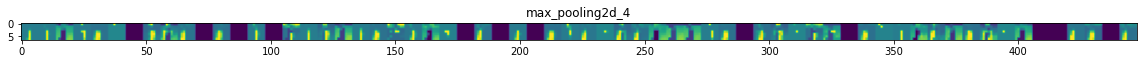

In [23]:
feature_maps = visualization_model.predict(x)

for layer_name, feature_map in zip(layer_names, feature_maps):
  if len(feature_map.shape) == 4:          # Just do this for convolutional layers, not after flatten layer
    num_features = feature_map.shape[-1]
    size = feature_map.shape[1]            # Since shape[0] is just 1
    display_grid = np.zeros((size, size * num_features))  # feature 각각의 size * size 이미지를 연속적으로 이어서 붙이기

    for i in range(num_features):
      ith_feature = feature_map[0, :, :, i]
      # Postprocess the feature to make it visually palatable
      ith_feature -= ith_feature.mean()
      ith_feature /= ith_feature.std()
      ith_feature *= 64
      ith_feature += 128

      # 0보다 작은 값들은 0, 255보다 큰 값들은 255로 보정
      ith_feature = np.clip(ith_feature, 0, 255).astype('uint8')

      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = ith_feature

    # Display the grid
    scale = 20 / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Loss & Accuracy Analysis

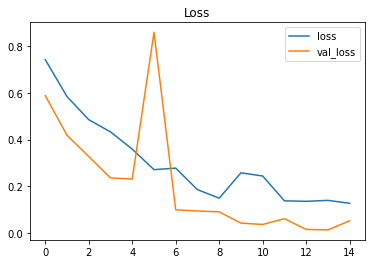

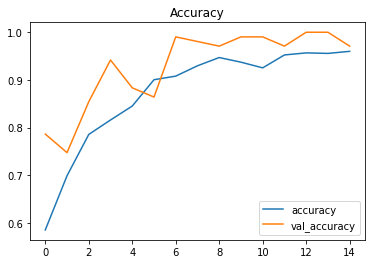

In [27]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(len(loss))

plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()